In [165]:
from commonfunctions import *
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from scipy.signal import argrelextrema
import cv2
import os
from skimage.filters import threshold_mean
from skimage import transform
from skimage.color import rgb2gray
from skimage.segmentation import flood, flood_fill
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from skimage.feature import peak_local_max

In [166]:
######## return hog features from input image #########
def extract_hog_features(img):
    target_img_size = (64, 64)
    img = cv2.resize(img, target_img_size)
    win_size = (64, 64)
    cell_size = (8, 8)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [167]:
import glob
x=[]
x = glob.glob("N:\Downloads\ACdata_base\\1\\*")
x.extend(glob.glob("N:\Downloads\ACdata_base\\2\\*"))
x.extend(glob.glob("N:\Downloads\ACdata_base\\3\\*"))
x.extend(glob.glob("N:\Downloads\ACdata_base\\4\\*"))
x.extend(glob.glob("N:\Downloads\ACdata_base\\5\\*"))
x.extend(glob.glob("N:\Downloads\ACdata_base\\6\\*"))
x.extend(glob.glob("N:\Downloads\ACdata_base\\7\\*"))
x.extend(glob.glob("N:\Downloads\ACdata_base\\8\\*"))
x.extend(glob.glob("N:\Downloads\ACdata_base\\9\\*"))
# images, y = load_images_from_folder(["N:\Downloads\ACdata_base\\7","N:\Downloads\ACdata_base\\9"])

    
images, y = load_images_from_folder(["N:\Downloads\ACdata_base\\1","N:\Downloads\ACdata_base\\2","N:\Downloads\ACdata_base\\3","N:\Downloads\ACdata_base\\4","N:\Downloads\ACdata_base\\5","N:\Downloads\ACdata_base\\6","N:\Downloads\ACdata_base\\7","N:\Downloads\ACdata_base\\8","N:\Downloads\ACdata_base\\9"])


In [168]:
####### return hog features from arr of images ###########
def feature_extraction_hog(images):
    feature = []
    for img in images:
        img = img.astype('uint8')
        img = cv2.resize(img, (64, 64), cv2.INTER_AREA)
        featuresHog = extract_hog_features(img.astype('uint8'))
        feature.append(featuresHog)
    return feature

In [169]:
######## binarize image ##########
def local_binarize(img, block_size = 35, offset_val = 10):
    img=img_as_ubyte(img)
    return img < threshold_otsu(img)


In [170]:
###### function that takes the folder of the dataset then returns array of images and their labels ########
def load_images_from_folder(folders):
    images = []
    y=[]
    i = 1
    for folder in folders:   
        for filename in os.listdir(folder):
            img = io.imread(os.path.join(folder,filename), as_gray = True)
            if img is not None:

                images.append(local_binarize(img))
                y.append(i)
        i+=1
    return images, y

In [188]:
############### function that extracts hog features from dataset ###################
def process_Hog():    
    features = feature_extraction_hog(images)
    return features, y

In [189]:
################ demo test for hog extraction from dataset using support vector machine
X, y = process_Hog()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
poly = svm.SVC(kernel='rbf', degree=3, C=5).fit(X_train, y_train)
poly_pred = poly.predict(X_test)
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))


Accuracy (Polynomial Kernel):  86.05
F1 (Polynomial Kernel):  85.88


In [173]:
####### function that returns the row of the text basline #######
def baseline(img):
    horizontal_projection = np.sum(img, axis=1)
    return np.argmax(horizontal_projection)


In [310]:
######### Horizontal profile projection ###########

from scipy.signal import find_peaks

def HPP(img):
    horizontal_projection = np.sum(img, axis=1)
    horizontal_projection=peak_local_max(horizontal_projection, min_distance=3).size
    return horizontal_projection


In [175]:
def count_contour(img,minArea):
    find_contour_img=find_contours(img,0.5)
    i=0
    vertical_lines_height = []
    max_height = 0.0001
    variance=0
    for box in find_contour_img:  
        Xmin=min(box[:,1])
        Xmax=max(box[:,1])
        Ymin=min(box[:,0])
        Ymax=max(box[:,0])
        if (Ymax-Ymin)*(Xmax-Xmin)>minArea:
            vertical_lines_height.append(Ymax-Ymin)
            i+=1
    if vertical_lines_height != []:
        max_height=max(vertical_lines_height)
        variance=np.var(vertical_lines_height)
    return i, max_height, variance

In [176]:
######### takes binary image and returns skeleton, edge, text-only, diacretecs image
def processing_images(binary_img):
    bw_img=binary_img
    baseline_i=baseline(bw_img)
    seeds=[]
    for j in range(bw_img.shape[1]-1):
        if(bw_img[baseline_i][j]==False and bw_img[baseline_i][j+1]==True):
            seeds.append(j+1)
    diacritics = bw_img
    for j in seeds:
        diacritics = flood_fill(diacritics, (baseline_i, j), False)
    text_only = bw_img != diacritics
    sobel_img = sobel(bw_img)
    skeletonized_img=skeletonize(bw_img)
    
    return sobel_img, skeletonized_img, diacritics, text_only

In [177]:
####### function that returns num of horizontal and vertical lines
def HVSL(bw_image):
    # hough line to detect lines in the photo
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 2)
    h, theta, d = hough_line(bw_image, theta=tested_angles)
    origin = np.array((0, bw_image.shape[1]))
    # hough peaks to get those lines
    angles=[]
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        angles.append(angle)
    angles = [angle * 180 / np.pi for angle in angles]
    return angles.count(90.0), angles.count(180.0)



In [178]:
################### 1st feature ##################
def HVSL_features(edge):
    vertical_lines, horizontal_lines = HVSL(edge)
    if(vertical_lines+horizontal_lines) == 0:
        horizontal_lines=.0001
    ratio_pixels_HVL = np.count_nonzero(edge)/(vertical_lines + horizontal_lines)
    return vertical_lines, horizontal_lines, ratio_pixels_HVL
    

In [308]:
def text_HVSL_feature(edge):
    edge = img_as_ubyte(edge)
    fld = cv2.ximgproc.createFastLineDetector()
    lines = fld.detect(edge)
    vertical_lines = (lines[:,0,0] == lines[:,0,2]).sum()
    horizontal_lines = (lines[:,0,1] == lines[:,0,3]).sum()
    if(vertical_lines+horizontal_lines) == 0:
        horizontal_lines=.0001
    freq_appearance_ratio = (vertical_lines+horizontal_lines)/len(lines)
    ratio_pixels_HVL = np.count_nonzero(edge)/freq_appearance_ratio
    return freq_appearance_ratio, ratio_pixels_HVL


In [180]:
def text_height_feature(skeleton):
    skeleton = img_as_ubyte(skeleton)
    kernel_vertical_line=np.ones((3,1))
    line = cv2.morphologyEx(skeleton, cv2.MORPH_OPEN, kernel_vertical_line)
    line=line/255
    num_of_verticle_lines, max_vertical_line_height, variance = count_contour(line,3*1)

    start_height=0
    end_height=0
    for i in range(line.shape[0]):
        if(np.any((line[i] == 1))):
            start_height = i
            break
    for i in range(line.shape[0]-1, 0, -1):
        if(np.any((line[i] == 1))):
            end_height = i
            break
    text_height = abs(start_height-end_height)
    return text_height, num_of_verticle_lines, max_vertical_line_height, text_height/max_vertical_line_height , variance



[[0.82666235 0.81881922 0.81097608 ... 1.         1.         1.        ]
 [0.83450549 0.82666235 0.81881922 ... 1.         1.         1.        ]
 [0.82274078 0.81881922 0.81489765 ... 1.         1.         1.        ]
 ...
 [0.73837804 0.73837804 0.73837804 ... 1.         1.         1.        ]
 [0.73445647 0.73445647 0.74229961 ... 1.         1.         1.        ]
 [0.73445647 0.73837804 0.74229961 ... 1.         1.         1.        ]]


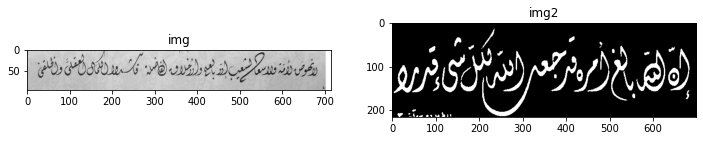

[[0.82666235 0.81881922 0.81097608 ... 1.         1.         1.        ]
 [0.83450549 0.82666235 0.81881922 ... 1.         1.         1.        ]
 [0.82274078 0.81881922 0.81489765 ... 1.         1.         1.        ]
 ...
 [0.73837804 0.73837804 0.73837804 ... 1.         1.         1.        ]
 [0.73445647 0.73445647 0.74229961 ... 1.         1.         1.        ]
 [0.73445647 0.73837804 0.74229961 ... 1.         1.         1.        ]] [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[0.82666235 0.81881922 0.81097608 ... 1.         1.         1.        ]
 [0.83450549 0.82666235 0.81881922 ... 1.         1.         1.        ]
 [0.82274078 0.81881922 0.81489765 ... 1.         1.         1.        ]
 ...
 [0.73837804 0.73837804 0.73837804 ... 1.         1.         1.     

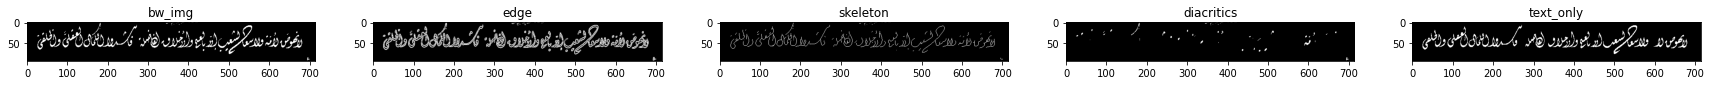

[0.07279693 0.05363985 0.03065134 0.02681992 0.01149425 0.01915709
 0.01532567 0.01915709 0.04214559 0.05747126 0.07662835 0.09578544
 0.08045977 0.07279693 0.06896552 0.06896552 0.05747126 0.04597701
 0.06130268 0.0651341  0.06896552 0.08429119 0.10727969 0.13793103
 0.16091954 0.18773946 0.18773946 0.1954023  0.21455939 0.23754789
 0.24521073 0.26819923 0.2835249  0.27586207 0.30651341 0.29118774
 0.31034483 0.3256705  0.39846743 0.47126437 0.53256705 0.6091954
 0.62835249 0.6091954  0.64750958 0.63984674 0.65900383 0.69348659
 0.67049808 0.66666667 0.61302682 0.57854406 0.6091954  0.651341
 0.69348659 0.75478927 0.91954023 1.         0.98084291 0.90038314
 0.59386973 0.30651341 0.14942529 0.09961686 0.06896552 0.06896552
 0.07279693 0.05363985 0.06130268 0.06130268 0.04597701 0.03831418
 0.04597701 0.03831418 0.03448276 0.03065134 0.02298851 0.01149425
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00766284 0.00766284 0.01149425 0.00766284
 0.022

(89, 124, 16.0, 5.5625, 4.492374479708636)

In [228]:
img = io.imread('N:\Downloads\ACdata_base\\1\\0034.jpg', 1)
print(img)

img2 = images[0]
        # target_img_size = (200, 200)
        # # img = cv2.resize(img, target_img_size, cv2.INTER_AREA)
show_images([img, img2],['img','img2'])
print(img,img2)
# bw_img=local_binarize(img)
edge, skeleton, diacritics, text_only = processing_images(bw_img)

print(img)
bw_img=local_binarize(img)
edge, skeleton, diacritics, text_only=processing_images(bw_img)
show_images([bw_img, edge, skeleton, diacritics, text_only],['bw_img', 'edge', 'skeleton', 'diacritics', 'text_only'])

HPP_features = HPP(bw_img)
print(HPP_features)
################### 1st feature ##################
HVSL_features(edge)
################## 3st feature ###################
text_height_feature(skeleton)



###############################
# line_width, line_space, _ = find_ref_lengths(bw_img)
# max_vertical_line_height, _, _ = find_ref_lengths(line)
# print(max_vertical_line_height,"max")
####################################


In [335]:
############### function that extracts hog features from dataset ###################
def process_LVL_HVSL():
    featuresLVL =[]
    featuresHVSL=[]
    HPP_features=[]
    featuresToE=[]
    featuresToS=[]

    for img in images:
        # img = img.astype('uint8')
        # img = cv2.resize(img, (400, 400))

        bw_img=img
        # img = io.imread(path, 1)
        # print(img)
        # # target_img_size = (200, 200)
        if(sum(img[0]>0)):
            bw_img= np.invert(bw_img)
        # img = color.rgb2gray(img)
        # print(img)
        # bw_img=local_binarize(img)
        edge, skeleton, diacritics, text_only = processing_images(bw_img)
        # show_images([edge, skeleton],['edge','skeleton'])
        # skeleton = skeleton.astype('uint8')
        # resized_skeleton = cv2.resize(skeleton, (64, 64), cv2.INTER_AREA)
        featuresLVL.append(text_height_feature(skeleton))
        featuresHVSL.append(text_HVSL_feature(edge))
        HPP_features.append(HPP(bw_img))

        edge = edge.astype('uint8')
        edge = cv2.resize(edge, (64, 64), cv2.INTER_AREA)
        skeleton = skeleton.astype('uint8')
        skeleton = cv2.resize(skeleton, (64, 64), cv2.INTER_AREA)

        featuresToS.append(extract_hog_features(skeleton.astype('uint8')))
        featuresToE.append(extract_hog_features(edge.astype('uint8')))

        # print(extract_hog_features(skeleton))

    return featuresLVL,featuresHVSL, HPP_features, featuresToS, featuresToE, y

In [336]:
# def process_HVSL():
#     features =[]
#     for path in x:
#         img = io.imread(path, 1)
#         bw_img=local_binarize(img)
#         edge, skeleton, diacritics, text_only=processing_images(bw_img)
#     return features, y

In [346]:
################ demo test for LVL extraction from dataset using Decision Trees
 
XLVL, XHVSL,XHPP, featuresToS, featuresToE,y = process_LVL_HVSL()
X_train, X_test, y_train, y_test = model_selection.train_test_split(XLVL, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
clf = DecisionTreeClassifier().fit(X_train, y_train)
clf_pred = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test, clf_pred)
clf_f1 = f1_score(y_test, clf_pred, average='weighted')
print('Accuracy (LVL): ', "%.2f" % (clf_accuracy*100))
print('F1 (LVL): ', "%.2f" % (clf_f1*100))

################# demo test for HVSL extraction from dataset using Decision Trees


X_train, X_test, y_train, y_test = model_selection.train_test_split(XHVSL, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
clf = DecisionTreeClassifier().fit(X_train, y_train)
clf_pred = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test, clf_pred)
clf_f1 = f1_score(y_test, clf_pred, average='weighted')
print('Accuracy (HVSL): ', "%.2f" % (clf_accuracy*100))
print('F1 (HVSL): ', "%.2f" % (clf_f1*100))


#########

X_train, X_test, y_train, y_test = model_selection.train_test_split(XHPP, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
X_train= np.array(X_train).reshape(-1, 1)
# # y_train= np.array( y_train).reshape(-1, 1)
X_test =  np.array(X_test).reshape(-1, 1)
# y_test=  np.array(y_test).reshape(-1, 1)
clf = DecisionTreeClassifier().fit(X_train, y_train)
clf_pred = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test, clf_pred)
clf_f1 = f1_score(y_test, clf_pred, average='weighted')
print('Accuracy (HPP): ', "%.2f" % (clf_accuracy*100))
print('F1 (HPP): ', "%.2f" % (clf_f1*100))


#########



In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(featuresToE, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
poly = svm.SVC(kernel='rbf', degree=3, C=5).fit(X_train, y_train)
poly_pred = poly.predict(X_test)
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))


Accuracy (Polynomial Kernel):  12.46
F1 (Polynomial Kernel):  2.76


In [ ]:
# ################# demo test for HVSL extraction from dataset using Decision Trees
# X, y = process_HVSL()
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
# clf = DecisionTreeClassifier().fit(X_train, y_train)
# clf_pred = clf.predict(X_test)
# clf_accuracy = accuracy_score(y_test, clf_pred)
# clf_f1 = f1_score(y_test, clf_pred, average='weighted')
# print('Accuracy (Polynomial Kernel): ', "%.2f" % (clf_accuracy*100))
# print('F1 (Polynomial Kernel): ', "%.2f" % (clf_f1*100))

